Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

Importing all the important libraries

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
!pwd

/content


In [6]:
2239+118

2357

In [7]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_Project/Skin cancer/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN_Project/Skin cancer/Test')

In [8]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


Create a dataset

- Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [11]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Visualize the data:
- create a code to visualize one instance of all the nine classes present in the dataset

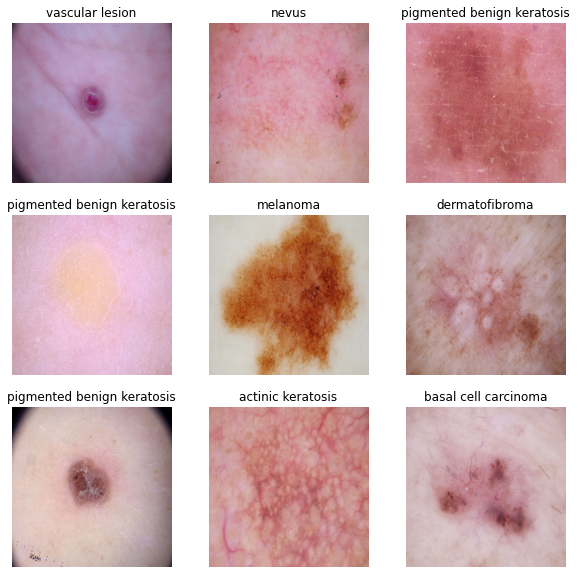

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
### your code goes here, you can use training or validation data to visualize

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.



In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

Compile the model:
- Choose an appropirate optimiser and loss function for model training

In [16]:
### Todo, choose an appropirate optimiser and loss function

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 180, 180, 32)     2432      
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 180, 180, 32)     25632     
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 90, 90, 32)       0         
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 90, 90, 32)       25632     
 pper)                                                  

## Train the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 55s 717ms/step - loss: 2.0696 - accuracy: 0.1975 - val_loss: 1.9736 - val_accuracy: 0.2461
Epoch 2/20
56/56 [==============================] - 4s 78ms/step - loss: 1.8747 - accuracy: 0.2935 - val_loss: 1.7082 - val_accuracy: 0.3714
Epoch 3/20
56/56 [==============================] - 4s 77ms/step - loss: 1.7149 - accuracy: 0.3672 - val_loss: 1.6688 - val_accuracy: 0.3669
Epoch 4/20
56/56 [==============================] - 4s 78ms/step - loss: 1.5888 - accuracy: 0.4358 - val_loss: 1.7820 - val_accuracy: 0.3445
Epoch 5/20
56/56 [==============================] - 4s 78ms/step - loss: 1.6163 - accuracy: 0.4230 - val_loss: 1.6058 - val_accuracy: 0.4922
Epoch 6/20
56/56 [==============================] - 4s 78ms/step - loss: 1.5254 - accuracy: 0.4621 - val_loss: 1.6544 - val_accuracy: 0.4564
Epoch 7/20
56/56 [==============================] - 4s 78ms/step - loss: 1.4737 - accuracy: 0.4805 - val_loss: 1.7259 - val_accuracy: 0.4295
Epoch 8/20


## Visualizing training results

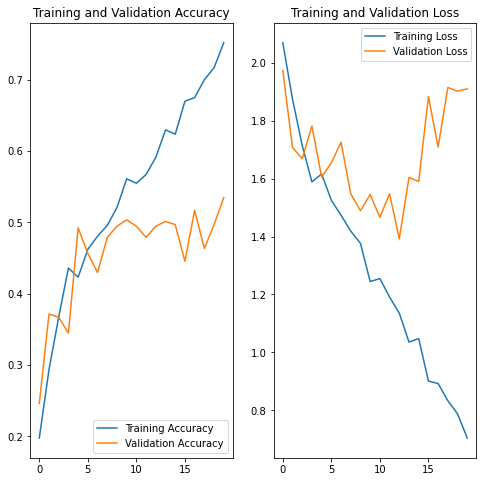

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

It is a base model and base the graph it is overfit the model so we need to do the augmentation layer.

- model is overfit
- need to do the augumention for the model
- it is a base model with mini understand from it we can see model is overfit
- batch normalization is need to be done.

In [20]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])


# Thus we can clearly that model Overfit and we need to chose right data augumentation strategy

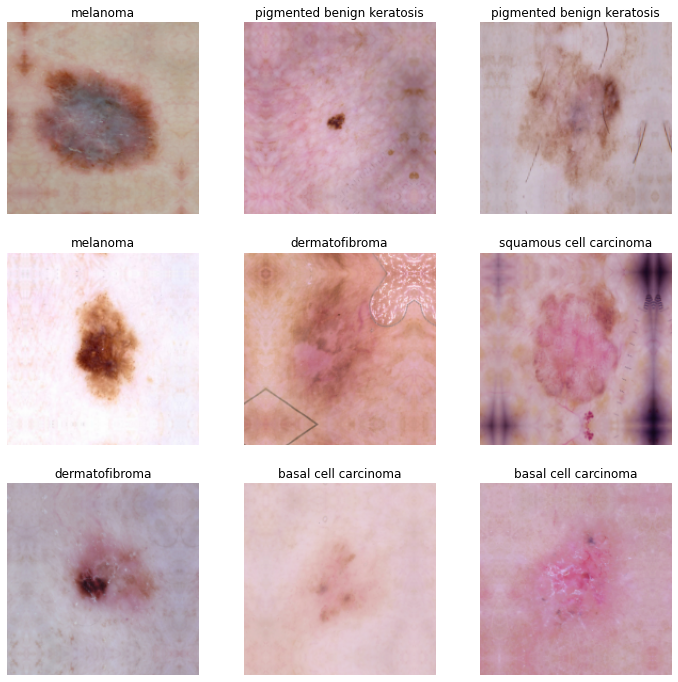

In [21]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Compiling the model

In [22]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 7s 93ms/step - loss: 2.0539 - accuracy: 0.1802 - val_loss: 2.0107 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 5s 94ms/step - loss: 2.0015 - accuracy: 0.2266 - val_loss: 1.9054 - val_accuracy: 0.2729
Epoch 3/20
56/56 [==============================] - 5s 87ms/step - loss: 2.0338 - accuracy: 0.2003 - val_loss: 2.0201 - val_accuracy: 0.2103
Epoch 4/20
56/56 [==============================] - 5s 87ms/step - loss: 1.9750 - accuracy: 0.2651 - val_loss: 2.0832 - val_accuracy: 0.2058
Epoch 5/20
56/56 [==============================] - 5s 87ms/step - loss: 2.0236 - accuracy: 0.2115 - val_loss: 2.0288 - val_accuracy: 0.2148
Epoch 6/20
56/56 [==============================] - 5s 87ms/step - loss: 2.0216 - accuracy: 0.2154 - val_loss: 2.0287 - val_accuracy: 0.2058
Epoch 7/20
56/56 [==============================] - 5s 88ms/step - loss: 2.0190 - accuracy: 0.1987 - val_loss: 1.9851 - val_accuracy: 0.1969
Epoch 8/20
56/56 [======

## Visualizing the results

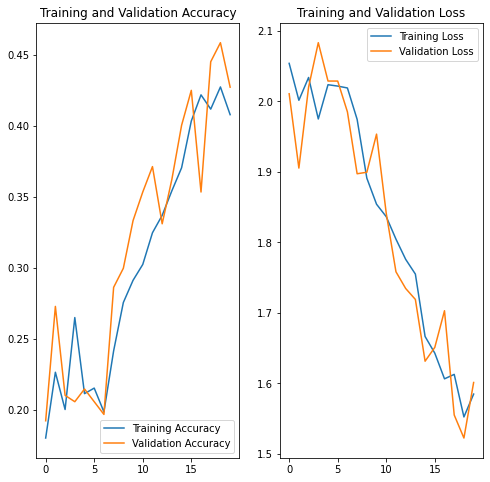

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


- Model performance is somewhat imporoved , but still it is underfit.
- Hyperparameter tuning is required.
- Need to add more samples or create samples by augumentation methods and drop out is 0.25
- Need to build the model for more Epoch

In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

## Visualizing the results

<BarContainer object of 9 artists>

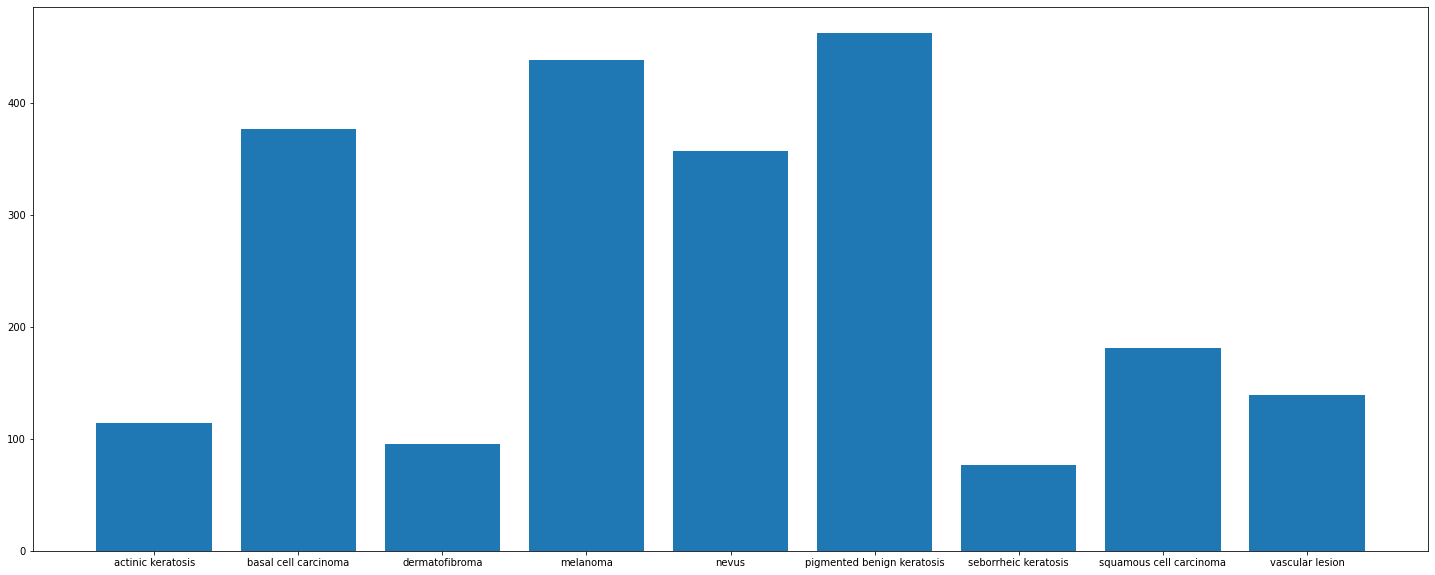

In [26]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

In [27]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run? Find the distribution of classes in the training dataset. Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [28]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
#path_to_training_dataset="/content/drive/MyDrive/Cancer Detection /Train"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline("/content/gdrive/MyDrive/CNN_Project/Skin cancer/Train",save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Project/Skin cancer/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD3E6387D10>: 100%|██████████| 500/500 [00:49<00:00, 10.08 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Project/Skin cancer/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD3E60E3C10>: 100%|██████████| 500/500 [00:46<00:00, 10.65 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Project/Skin cancer/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD3E6387750>: 100%|██████████| 500/500 [00:35<00:00, 14.02 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Project/Skin cancer/Train/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FD3E65CC510>: 100%|██████████| 500/500 [00:45<00:00, 10.91 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Project/Skin cancer/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD3E63B0410>: 100%|██████████| 500/500 [00:44<00:00, 11.19 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Project/Skin cancer/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD3E6ED57D0>: 100%|██████████| 500/500 [00:48<00:00, 10.35 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Project/Skin cancer/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD3E6E28CD0>: 100%|██████████| 500/500 [00:42<00:00, 11.68 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Project/Skin cancer/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD3E613FE10>: 100%|██████████| 500/500 [00:46<00:00, 10.77 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Project/Skin cancer/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD3E6468FD0>: 100%|██████████| 500/500 [00:35<00:00, 14.11 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [30]:
data_dir_train1 = pathlib.Path("/content/gdrive/MyDrive/CNN_Project/Skin cancer/Train/output")
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

4500


In [31]:
data_dir_test1 = pathlib.Path("/content/gdrive/MyDrive/CNN_Project/Skin cancer/Test")
image_count_test1 = len(list(data_dir_test1.glob('*/*.jpg')))
print(image_count_test1)

118


In [32]:
data_dir_train1

PosixPath('/content/gdrive/MyDrive/CNN_Project/Skin cancer/Train/output')

In [33]:
path_list = [x for x in glob(os.path.join(data_dir_train1, '*','output', '*.jpg'))]
path_list

[]

In [34]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train1, '*','output', '*.jpg'))]
lesion_list_new

[]

In [35]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [37]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [38]:
new_df['Label'].value_counts()

Series([], Name: Label, dtype: int64)

### Train the model on the data created using Augmentor

In [39]:
batch_size = 32
img_height = 180
img_width = 180

Create a training dataset

In [40]:
data_dir_train=data_dir_train1
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


Create a validation dataset

In [41]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


Create your model (make sure to include normalization)

In [46]:
num_classes = 9
model = Sequential([   
    layers.Rescaling(scale=1./255., input_shape = (180, 180, 3))
])

model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.50))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.50))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(num_classes, activation = "softmax"))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 90, 90, 16)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 90, 90, 32)       

Compile your model (Choose optimizer and loss function appropriately)

In [47]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Train your model

In [48]:
epochs = 30

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


113/113 [==============================] - 21s 167ms/step - loss: 6.2783 - accuracy: 0.2869 - val_loss: 16.1915 - val_accuracy: 0.1489
Epoch 2/30
113/113 [==============================] - 18s 152ms/step - loss: 1.8107 - accuracy: 0.3656 - val_loss: 12.0149 - val_accuracy: 0.1678
Epoch 3/30
113/113 [==============================] - 19s 161ms/step - loss: 1.6888 - accuracy: 0.3989 - val_loss: 7.8882 - val_accuracy: 0.2389
Epoch 4/30
113/113 [==============================] - 18s 152ms/step - loss: 1.5757 - accuracy: 0.4300 - val_loss: 5.7075 - val_accuracy: 0.3689
Epoch 5/30
113/113 [==============================] - 19s 161ms/step - loss: 1.5024 - accuracy: 0.4753 - val_loss: 4.7274 - val_accuracy: 0.3822
Epoch 6/30
113/113 [==============================] - 18s 151ms/step - loss: 1.4401 - accuracy: 0.4889 - val_loss: 9.2274 - val_accuracy: 0.3744
Epoch 7/30
113/113 [==============================] - 18s 151ms/step - loss: 1.4538 - accuracy: 0.4847 - val_loss: 6.0028 - val_accuracy: 0

Visualize the model results

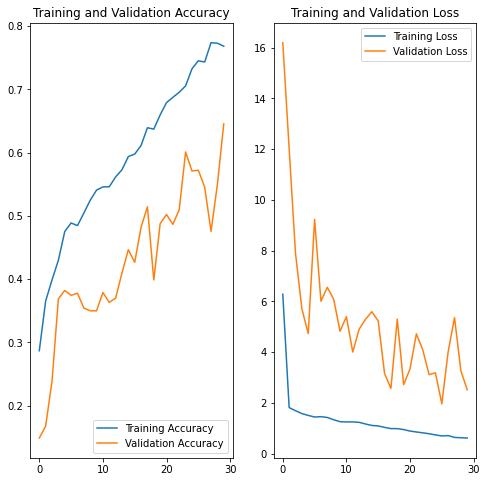

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Accuracy has got increased after including the augumented samples using Augmentor library.

- Model performance is somewhat imporoved , but still it is overfitting.
- Hyperparameter tuning is required.
- Need to add more samples or create samples by augumentation methods.
- Need to build the model for more Epoch
- Model need to imporve a lot